# Anomaly Detection and Recommender Systems

In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import numpy.linalg as la
import scipy.optimize as op
from scipy.stats import norm
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures 
from matplotlib import pyplot as plt

## Anomaly Detection

### Load and Plot data

In [2]:
matdata = loadmat('data/ex8data1.mat')
matdata.keys()
X = matdata['X']
Xval = matdata['Xval']
yval = matdata['yval']

In [3]:
print('X.shape:', X.shape)
print('Xval.shape:', Xval.shape)
print('yval.shape:', yval.shape)

X.shape: (307, 2)
Xval.shape: (307, 2)
yval.shape: (307, 1)


In [5]:
boolArr = [yval == 1]
print("number of anomoly:",len(yval[boolArr]), "perc of anomoly:", len(yval[boolArr])/len(yval))

number of anomoly: 9 perc of anomoly: 0.029315960912052116


/Users/juersong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Text(0, 0.5, 'Throughput (mb/s)')

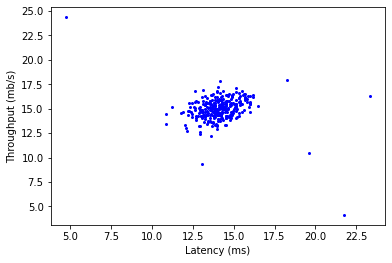

In [6]:
# Visualize the example dataset
plt.plot(X[:,0], X[:,1], 'bo', markersize=2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

### Fit Gaussian distribution

#### Using scipy.stats

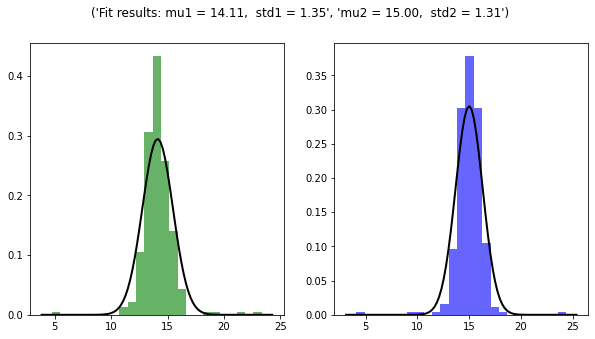

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mu1, std1 = norm.fit(X[:,0])
mu2, std2 = norm.fit(X[:,1])

# Plot the histogram.
axes[0].hist(X[:,0], bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu1, std1)
axes[0].plot(x, p, 'k', linewidth=2)

# Plot the histogram.
axes[1].hist(X[:,1], bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu2, std2)
axes[1].plot(x, p, 'k', linewidth=2)

title = "Fit results: mu1 = %.2f,  std1 = %.2f" % (mu1, std1), "mu2 = %.2f,  std2 = %.2f" % (mu2, std2)
plt.suptitle(title)

plt.show()

#### Fit the data manually

In [24]:
# Estimating parameters for a Gaussian

def estimateGaussian(X):
    # X is a d * m matrix, d is the number of features, m is the sample size.
    
    d = X.shape[0]
    m = X.shape[1]
    
    # Initialize vector mu and sigma. Both vectors are (d, 1)
    mu = np.zeros([d, 1])
    sigma2 = np.zeros([d,1])
    
    for i in range(d):
        mu[i] = np.mean(X[i])
        sigma2[i] = np.mean((X[i] - mu[i])**2)

    return mu, sigma2

In [25]:
mu, sigma2 = estimateGaussian(X = X.T)

In [26]:
mu, sigma2

(array([[14.11222578],
        [14.99771051]]), array([[1.83263141],
        [1.70974533]]))

In [27]:
def multivariateGaussian(X, mu, Sigma2):
    # The function computes the probability density function of the multivariate gaussian distribution.
    # With mu and Sigma2. If Sigma2 is a matrix, it is treated as the covariance matrix. 
    # If Sigma2 is a vector, it istreated as the sigma^2 values of the variances in each dimension (a diagonal 
    # covariance matrix)
    
    d = X.shape[1]
    prob = []
    
    for i in range(d):
        p = ((2 * math.pi) ** (- 1 / 2)) * (Sigma2[i] ** (-0.5)) * np.exp(-0.5 * ((X[:,i] - mu[i])**2) / Sigma2[i] )
        prob.append(p)
    
    prob = np.array(prob)
    prob = np.product(prob, axis =0)

    return prob

(625, 2)


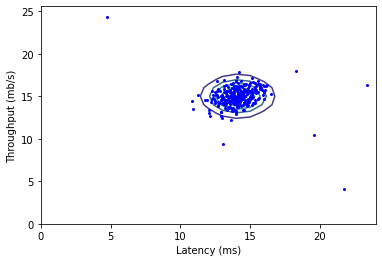

In [31]:
x = np.arange(0, 25,1)
y = np.arange(0, 25,1)
xx, yy = np.meshgrid(x, y)
x1 = xx.flatten().reshape(-1,1)
x2 = yy.flatten().reshape(-1,1)
x3 = np.column_stack((x1,x2))
print(x3.shape)
z = multivariateGaussian(x3, mu, sigma2)
z = z.reshape(xx.shape)
h = plt.contour(xx,yy,z)
plt.plot(X[:,0], X[:,1], 'bo', markersize=2)
plt.xlabel('Latency (ms)');
plt.ylabel('Throughput (mb/s)');
plt.show()

### Select threshhold

In [36]:
pval = multivariateGaussian(Xval, mu, sigma2)

In [37]:
def selectThreshold(yval, pval):
    
    # Find the best threshold (epsilon) to use for selecting outliers
    # based on the results from a alidation set (pval) and the ground truth (yval)

    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    stepsize = (np.max(pval) - np.min(pval)) / 1000
    for epsilon in np.arange(np.min(pval) ,np.max(pval),stepsize):
        yh = (pval < epsilon).reshape(-1,1)
        tp = (yh == yh) & (yval ==1)
        TP = np.sum(tp)

        tn = (yh == yh) & (yval ==0)
        TN = np.sum(tn)
        
        fp = (yh == 1) & (yval == 0)
        FP = np.sum(fp)
        
        fn = (yh == 0) & (yval == 1)
        FN = np.sum(fn)
        
        precision = TP /(TP + FP)
        recall = TP / (TP + FN)
        
        F1 = 2 * (precision * recall)/(precision + recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

   
    return bestEpsilon, bestF1  

In [38]:
bestEpsilon, bestF1   = selectThreshold(yval, pval)

In [39]:
print('threshold = ', bestEpsilon)
print('best F1 score = ', bestF1 )

threshold =  8.990852779269496e-05
best F1 score =  0.9


### High dimensional dataset

In [40]:
matdata = loadmat('data/ex8data2.mat')
matdata.keys()
X2 = matdata['X']
X2val = matdata['Xval']
y2val = matdata['yval']

In [41]:
print('X2.shape:', X2.shape)
print('X2val.shape:', X2val.shape)
print('y2val.shape:', y2val.shape)

X2.shape: (1000, 11)
X2val.shape: (100, 11)
y2val.shape: (100, 1)


In [42]:
# Cross validation set:
boolArr2 = [y2val == 1]
print("number of anomoly:",len(y2val[boolArr2]), "perc of anomoly:", len(y2val[boolArr2])/len(y2val))

number of anomoly: 10 perc of anomoly: 0.1


/Users/juersong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
# Fit Gaussian distribution parameters:
MU, SIGMA2 = estimateGaussian(X = X2.T)

In [44]:
pval2 = multivariateGaussian(X2val, MU, SIGMA2)

In [45]:
bestEpsilon2, bestF1_2  = selectThreshold(y2val, pval2)
print('threshold = ', bestEpsilon2)
print('best F1 score = ', bestF1_2 )

threshold =  1.3772288907613581e-18
best F1 score =  0.6666666666666667


## Movie Recommendation

### Load and Plot data

In [46]:
moviedata = loadmat('data/ex8_movies.mat')
moviedata.keys()
Y = moviedata['Y']
R = moviedata['R']

In [47]:
# nu = 943 users, and nm = 1682 movies
print('Y.shape:', Y.shape)
print('R.shape:', R.shape)

Y.shape: (1682, 943)
R.shape: (1682, 943)


In [48]:
Y[0, R[0, :]].shape

(943,)

In [49]:
# Y is a 1682 * 943 matrix, containing ratings (1-5) of 1682 movies on 943 users
# R is a 1682 * 943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5\n\n' % np.mean(Y[0, R[0, :]]))

Average rating for movie 1 (Toy Story): 4.520679 / 5




[IMAGESC] WARNING: Plot will be poorly visible if [linewidth>0] with rows/columns>100. Set linewidth=0 to adjust. [auto-adjusting...]


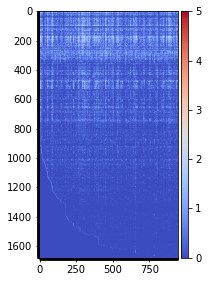

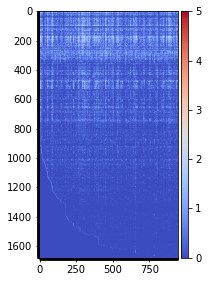

In [50]:
# We can "visualize" the ratings matrix by plotting it with imagesc
import imagesc as imagesc
imagesc.plot(Y)

### Collabrotive filtering cost function

In [74]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, bambda):
 # Collaborative filtering cost function returns the cost and gradient for the collaborative filtering problem.

    # Unfold the U and W matrices from params
    X = params[0: num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    # Notes:
    # Theta[j] - parameter vector for user j
    # X[i] - feature vector for movie i
    # X[i] @ Theta[j].T  - predicted rating for movie i by user j
    

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # Before regularization
    Diff = (X @ Theta.T - Y) * R
    
    J = 0.5 * (la.norm(Diff)**2)
    
    J_reg = J + 0.5 * bambda * np.sum(X*X)  + 0.5 * bambda * np.sum(Theta * Theta)
    
    X_grad = ((X @ Theta.T - Y)*R) @ Theta + bambda * X
    Theta_grad = ((X @ Theta.T - Y)*R).T @ X + bambda * Theta
    param_grad = np.append(X_grad, Theta_grad)
    
    return J, J_reg, param_grad


def f(params, Y, R, num_users, num_movies, num_features, bambda):
    return cofiCostFunc(params, Y, R, num_users, num_movies, num_features, bambda)[1]

def fprime(params, Y, R, num_users, num_movies, num_features, bambda):
    return cofiCostFunc(params, Y, R, num_users, num_movies, num_features, bambda)[2]

In [57]:
# Normalize ratings by substracting mean 
def normalizeRatings(Y, R):
    # Preprocess data by subtracting mean rating for every movie (every row)
    # so that each movie has a rating of 0 on average, and returns the mean rating in Ymean.

    m, n = Y.shape
    Ymean = np.zeros([m, 1])
    Ynorm = np.zeros([m, n])
    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i].item()

    return Ynorm, Ymean

In [59]:
#  Reduce the data set size so that this runs faster

num_users = 4
num_movies = 5
num_features = 3
bambda = 1.5
X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

params = np.append(X , Theta).reshape(-1,1)

# Evaluate cost function
J, J_reg, param_grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, bambda)

print('Cost at loaded parameters: %f '
         '\n(this value should be about 22.22)\n'% J)
print('Cost after regularization at loaded parameters: %f '
         '\n(this value should be about 31.34)\n'% J_reg)

Cost at loaded parameters: 22.224604 
(this value should be about 22.22)

Cost after regularization at loaded parameters: 31.344056 
(this value should be about 31.34)



### Learning movie recommendations

In [536]:
# Optimize using scipy.optimize.fmin_cg

In [69]:
# Load pre-trained weights: X, Theta, num_users, num_movies, num_features)
movieParams = loadmat('data/ex8_movieParams.mat')
movieParams.keys()
X = movieParams['X']
Y = moviedata['Y']
R = moviedata['R']
Theta = movieParams['Theta']
num_users = movieParams['num_users'].item()
num_movies = movieParams['num_movies'].item()
num_features = movieParams['num_features'].item()

In [71]:
## Randomly initialize the weights to small values
W = num_movies * num_features+ num_users * num_features
initial_params = np.random.rand(W, 1)

In [72]:
Ynorm, Ymean = normalizeRatings(Y, R)

In [75]:
retval = op.fmin_cg(f = f, 
           x0 = initial_params.squeeze(), 
           fprime = fprime, 
           args = (Ynorm, R, num_users, num_movies, num_features,10)
            )

Optimization terminated successfully.
         Current function value: 38944.658742
         Iterations: 396
         Function evaluations: 579
         Gradient evaluations: 579


In [76]:
# Avg error:
38944.658742/(num_users *num_movies)

0.02455331968708665